# Imports

In [1]:
# Add the directory where starships' directory is located
from sys import path
path.append('/home/mathisb/Github/')

# Add the directory containing the input data (opacity, abundance and stellar specs files)
import os
os.environ['pRT_input_data_path'] = '/home/mathisb/projects/def-ncowan/input_data'

from pathlib import Path

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from importlib import reload
import starships.plotting_fcts as pf 

import astropy.units as u
import astropy.constants as const

from starships import homemade as hm
from itertools import product

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
# %matplotlib notebook
%matplotlib inline

# Setting plot parameters
couleurs = hm.get_colors('magma', 50)[5:-2]

# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler(color=hm.get_colors('magma', 50))
# ex : list_of_color = [(i,0,0) for i in np.arange(10)/10]

In [5]:
from starships.correlation_class import Correlations
import starships.correlation_class as cc
from starships import correlation as corr

cc=reload(cc)

import starships.planet_obs as pl_obs
from starships.planet_obs import Observations,Planet

pl_obs=reload(pl_obs)

# Get planet info and determine directories to use

In [6]:
#-----------------------------------------------------------#
# Planet name and parameters
pl_name = 'TRAPPIST-1 b'
planet_obj=Planet(pl_name)

# Most parameters from trappist.one website
planet_obj.ap     = 0.01150*u.au       # semi-major axis of planet
planet_obj.R_star = 0.121*u.R_sun      # radius of star
planet_obj.R_pl   = 1.127*u.R_earth    # radius of planet
planet_obj.M_star = 0.089*const.M_sun  # mass of star
planet_obj.e      = 0                  # eccentricity
planet_obj.w      = 4.712389*u.rad     # argument of periapsis (equal to 270 degrees)
planet_obj.mid_tr = 2459514.805984833954*u.d  # mid-transit time (calculated from TTV BJD, Agol et al. 2021)
#-----------------------------------------------------------#

Getting TRAPPIST-1 b from ExoFile


In [7]:
#-----------------------------------------------------------#
# Where to find the reductions
instrument = "SPIRou"
reduc_version = 'v009'
reduc_in_scratch = True  # the reductions are in the scratch directory (True) or in the home directory (False)

# Indicate which reductions to use (sequence files)
filename_list = ["sequence_1-pc_mask_wings96_data_trs_night1.npz",
                 # "sequence_2-pc_mask_wings96_data_trs_night1.npz",
                 # "sequence_3-pc_mask_wings97_data_trs_night1.npz",
                 # "sequence_4-pc_mask_wings97_data_trs_night1.npz",
                 # "sequence_5-pc_mask_wings97_data_trs_night1.npz",
                 # "sequence_6-pc_mask_wings97_data_trs_night1.npz",
                 # "sequence_7-pc_mask_wings97_data_trs_night1.npz",
                 # "sequence_8-pc_mask_wings97_data_trs_night1.npz",
                ]
#-----------------------------------------------------------#

# Directory where the reductions are
if reduc_in_scratch:
    base_dir = Path(os.environ['SCRATCH'])
else:
    base_dir = Path.home()

pl_name_fname = ''.join(pl_name.split())

reduc_dir = base_dir / Path(f'HRS_reductions/{instrument}/{pl_name_fname}/{reduc_version}')

# Load reductions
obs_list = []
for filename in filename_list:
    obs = pl_obs.load_single_sequences(filename, pl_name, path=reduc_dir,
                              load_all=False, filename_end='', plot=False, planet=planet_obj)
    obs_list.append(obs)

Transmission


In [8]:
#-----------------------------------------------#
# Where to output the correlations
output_dir = base_dir / Path(f'HRS_correlations/{pl_name_fname}')
#-----------------------------------------------#

# Create output directory if it does not exist
output_dir.parent.mkdir(parents=True, exist_ok=True)

print("Reductions directory is:", reduc_dir)
print("Correlations directory is:", output_dir)

Reductions directory is: /scratch/mathisb/HRS_reductions/SPIRou/TRAPPIST-1b/v009
Correlations directory is: /scratch/mathisb/HRS_correlations/TRAPPIST-1b


# Read pre-generated model

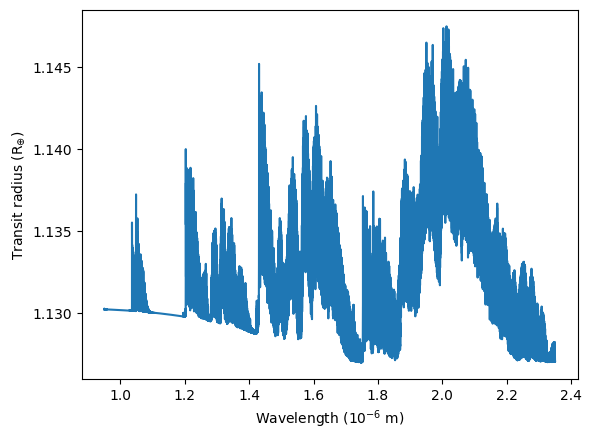

In [9]:
#-------------------------------------------------------------#
# Where to find the models
model_directory = "/home/mathisb/Github/HRS_models/"

# Name of npz model file
model_filename = "prt_model_TRAPPIST-1b_CO2_v02.npz"
#-------------------------------------------------------------#

model_file = np.load(model_directory + model_filename)
wave_mod, model_spec = model_file['wave_mod'], model_file['model_spec']

# Plot it
plt.plot(wave_mod, model_spec)

plt.xlabel('Wavelength ($10^{-6}$ m)')
plt.ylabel(r'Transit radius ($\rm R_{\oplus}$)')
plt.show()

# Correlations

In [10]:
#----------------------------------------------------------#
# Cross-correlation axes
n_RV_inj = 151
corrRV0 = np.linspace(-150, 150, n_RV_inj)  # x axis (Vsys)

kind_trans = 'transmission'  # emission or transmission
#----------------------------------------------------------#

# GENERATE KP/VSYS MAP
model_name = model_filename[10:][:-4]

n_pc_list = []
mask_wings_list = []
all_obs = dict()
all_ccf_map = dict()
all_logl_map = dict()

for filename in filename_list:
    obs = pl_obs.load_single_sequences(filename, pl_name, path=reduc_dir,
                              load_all=False, filename_end='', plot=False, planet=planet_obj)
    
    visit_name = filename.split(sep="_")[-1][:-4]
    
    # Generate Kp 
    Kp_array = np.array([obs.Kp.value]) 
        
    n_pc = int(obs.params[5])
    n_pc_list.append(n_pc)
    
    mask_wings = int(obs.params[1] * 100)  # in percent
    mask_wings_list.append(mask_wings)
    
    out_filename = f'{Path(filename).stem}_ccf_logl_seq_{model_name}'
    
    try:
        # Check if already generated
        saved_values = np.load(output_dir / Path(out_filename).with_suffix('.npz'))
        ccf_map = saved_values['corr']
        logl_map = saved_values['logl']
    except FileNotFoundError:
        # Generate 1d correlations
        # ccf_map shape: (n_exposures, n_order, n_Kp, n_vsys, n_pc, n_model) 
        ccf_map, logl_map = corr.calc_logl_injred(obs,
                            'seq', planet_obj, Kp_array, corrRV0, [n_pc], wave_mod, model_spec, kind_trans)
    
        corr.save_logl_seq(output_dir / Path(out_filename), ccf_map, logl_map,
                           wave_mod, model_spec, n_pc, Kp_array, corrRV0, kind_trans)
    
    all_obs[(n_pc, mask_wings)] = obs
    all_ccf_map[(n_pc, mask_wings)] = ccf_map
    all_logl_map[(n_pc, mask_wings)] = logl_map
    

Transmission


n_pc:  1
Max value at 1 npc = 1.8005687497719793 at -2.820413085694458 km/s
Max value at 1 npc = 1.3802002018523583 at -3.1312939955892665 km/s
Max value at 1 npc = 1.3802002018523583 at -3.1312939955892665 km/s
CCF SNR peak at Vsys*: [1.80056875]
log(L) abs peak at Vsys*: [-5360845.57797259]
log_10(ΔBIC) peak at Vsys*: [1.97440386e-07]
[0.]
(16, 151)
(array([55, 56, 57]),)
In-transit t-val = 1.47 / p-val 1.67e-01 / sig = 0.97
Out-of-transit t-val = 1.05 / p-val 3.02e-01 / sig = 0.52

Information about the plots:

    |  Plot CCF SNR, log likelihood and log10 ΔBIC (Bayesian information criterion) as a function of nPC to determine
    |  what is the best number of principal components to remove. Plot a SNR map using this best value of nPC.
    

        |  Plot some statistical measure of signal strength vs Vsys (on the right) and a peak value of that vs
        |  nPC (on the left).
    
        |  This function generates two plots arranged side by side. The plot on the right shows a s

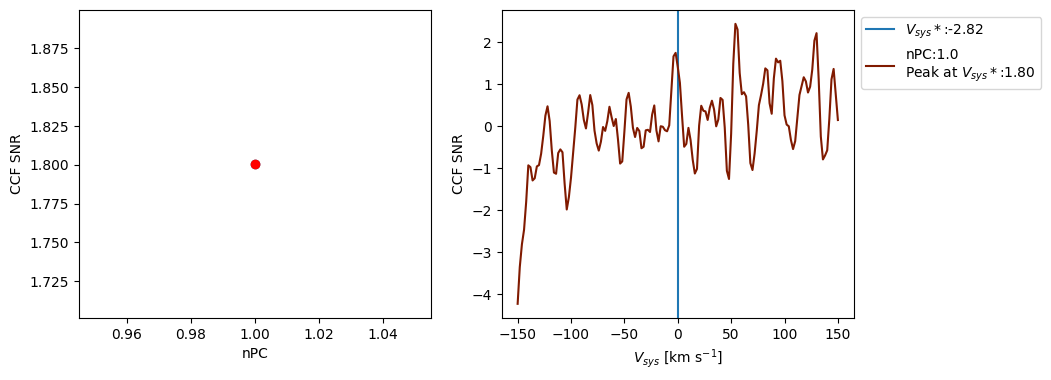

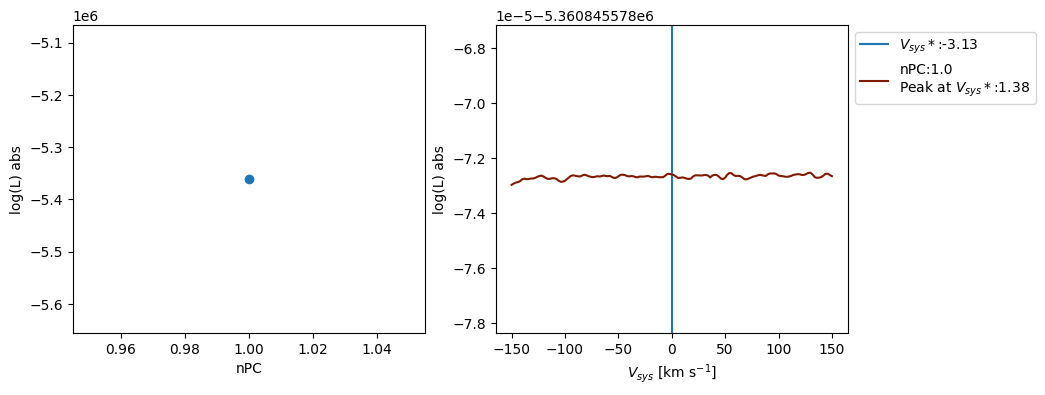

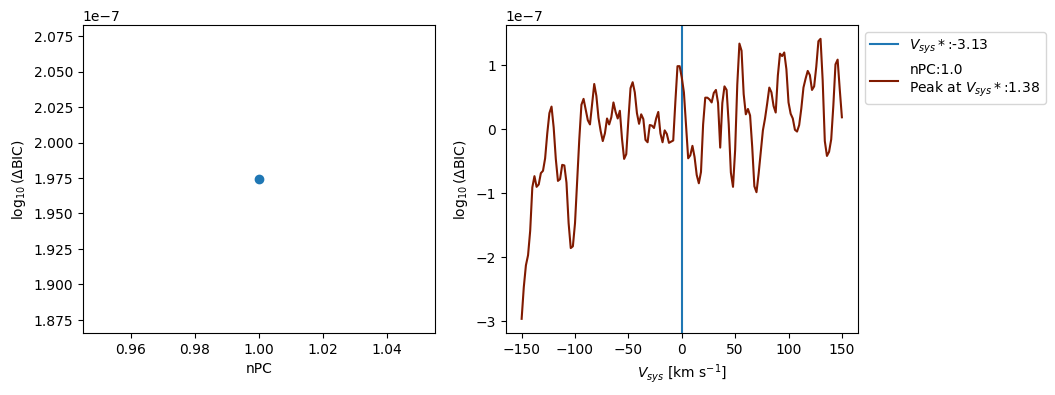

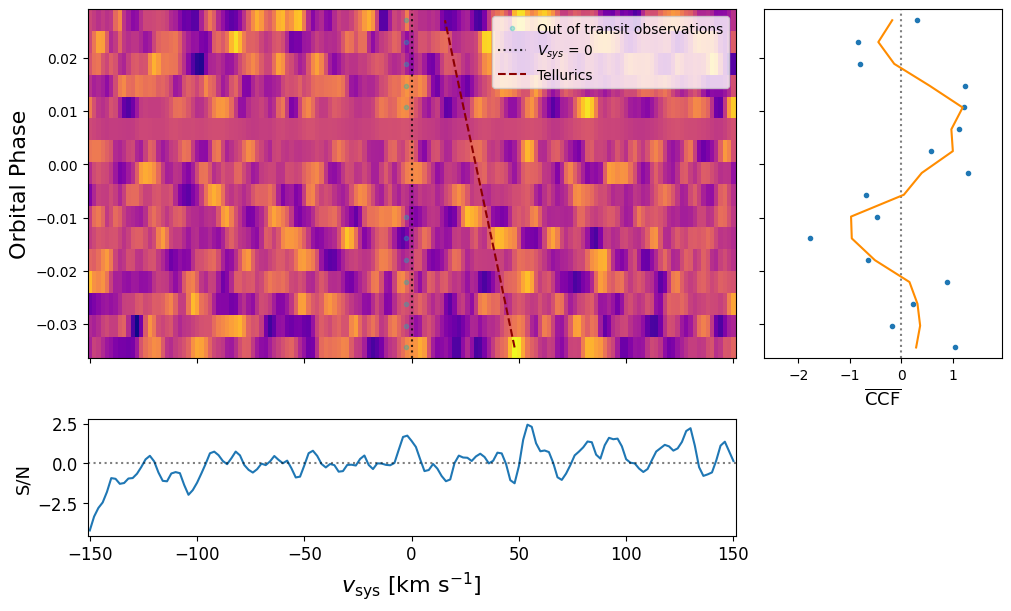

In [11]:
#----------------------------------------------#
# Indicate orders to use
nb_orders = 49  # number of orders in reduction
orders_to_delete = [[47, 48]]  # indices of orders that should not be used
#----------------------------------------------#

order_indices = np.arange(nb_orders)

# Remove each element of orders_to_delete from array of orders
for elem in orders_to_delete:
    order_indices = np.setdiff1d(order_indices, elem)


n_pc_list = np.unique(n_pc_list)
mask_wings_list = np.unique(mask_wings_list)


# Plot all ccf and logl as a function of pc
for n_pc in n_pc_list:
    ccf_maps_in = [all_ccf_map[(n_pc, mask_wings)] for mask_wings in mask_wings_list]
    ccf_maps_in = np.concatenate(ccf_maps_in, axis=-1)
    logl_maps_in = [all_logl_map[(n_pc, mask_wings)] for mask_wings in mask_wings_list]
    logl_maps_in = np.concatenate(logl_maps_in, axis=-1)
    obs = all_obs[(n_pc, mask_wings_list[0])]
    print('n_pc: ', n_pc)

    
    ccf_obj, logl_obj = cc.plot_ccflogl(obs, ccf_maps_in, logl_maps_in, corrRV0,
                                        Kp_array, n_pc_list, swapaxes=(-2, -1))

# Print info about the plots
print("\nInformation about the plots:\n" + cc.plot_ccflogl.__doc__ + "\n" + 
      Correlations.plot_multi_npca.__doc__ + "\n" + Correlations.plot_PRF.__doc__)


Transmission
Max value at 1 npc = 1.9760286125821274 at -2.831823815652807 km/s
Max value at 1 npc = 1.478421334012263 at -3.128149315319237 km/s
Max value at 1 npc = 1.478421334012263 at -3.128149315319237 km/s
CCF SNR peak at Vsys*: [1.97602861]
log(L) abs peak at Vsys*: [-5248935.85904154]
log_10(ΔBIC) peak at Vsys*: [1.97440386e-07]
[0.]
(16, 151)
(array([55, 56, 57]),)
In-transit t-val = 1.48 / p-val 1.66e-01 / sig = 0.97
Out-of-transit t-val = 1.05 / p-val 3.02e-01 / sig = 0.52


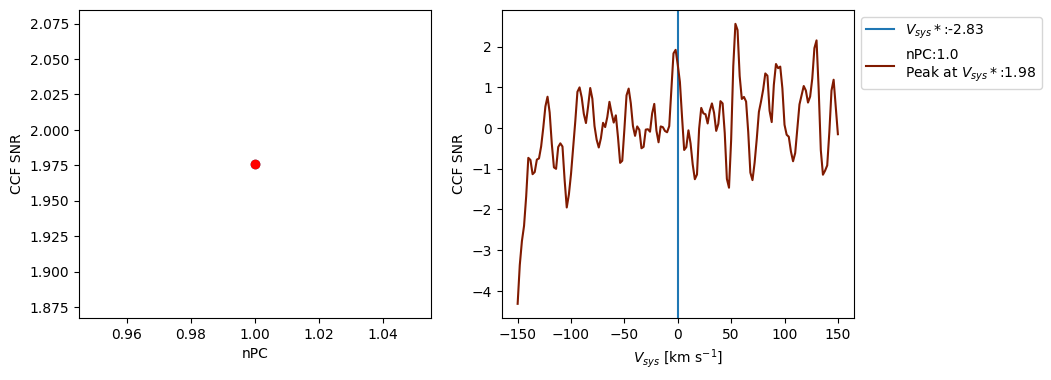

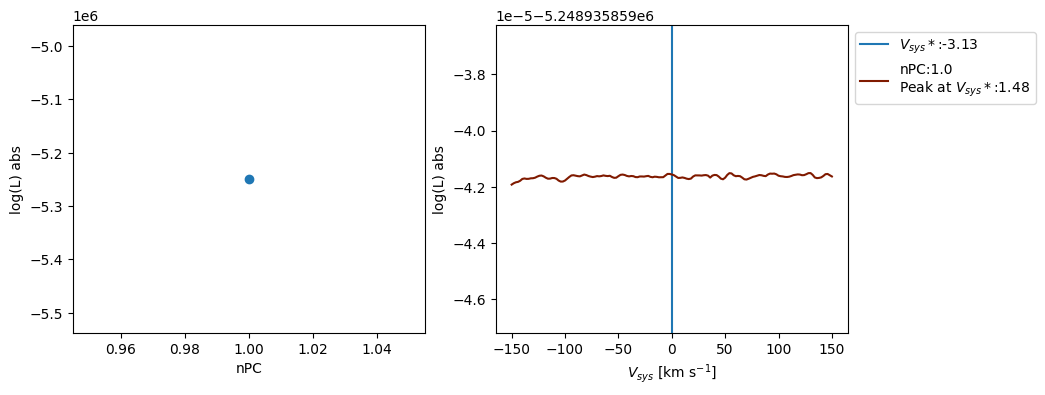

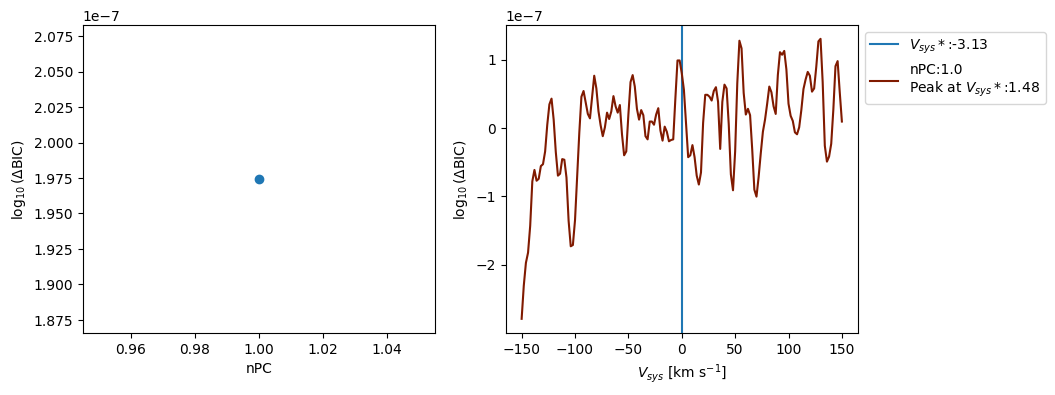

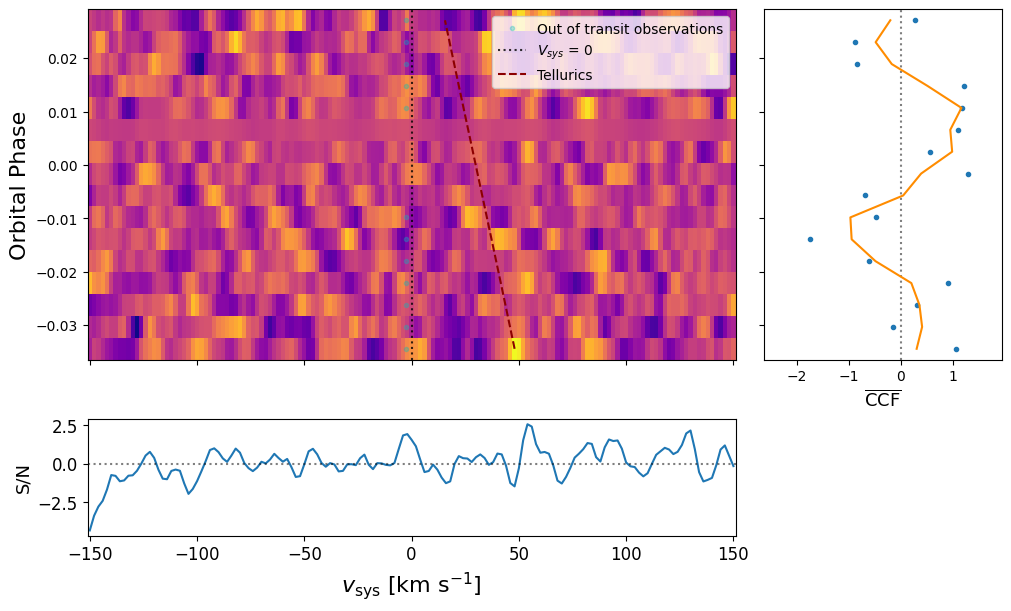

In [12]:
# Plot single ccf and logl
n_pc, mask_wings = 1, 96

filename = f'sequence_{n_pc}-pc_mask_wings{mask_wings}_data_trs_{visit_name}.npz'
obs = pl_obs.load_single_sequences(filename, pl_name, path=reduc_dir,
                              load_all=False, filename_end='', plot=False, planet=planet_obj)

args = [all_something[(n_pc, mask_wings)]
        for all_something in [all_obs, all_ccf_map, all_logl_map]]
ccf_obj, logl_obj = cc.plot_ccflogl(*args, corrRV0, Kp_array, [n_pc], orders=order_indices)

T-val : Max value = 1.9 // Max position = -1.3
Histogram for Kp = 82.83 and RV = -2.83
1.7848839506492948 0.10060622875480436 1.2781048544859026

Information about the plots:

    |  Plot Kp/Vsys map, T-test and Trail.
    
    |  In the Kp/Vsys map, the dotted lines indicate the known Kp/Vsys values of the planet. A signal at their
    |  intersection signifies a detection.
    
    |  The T-test plot tells us if the in-trail and out-of-trail distributions (both randomly selected values,
    |  respectively close to and far from the Vsys of the planet) are drawn from the same parent distribution.
    
    |  The trail plot is where the values used in the T-test are drawn from. The region outside of the black lines
    |  but within the red ones is not used because it is unclear if it is in-trail or out-of-trail.
    


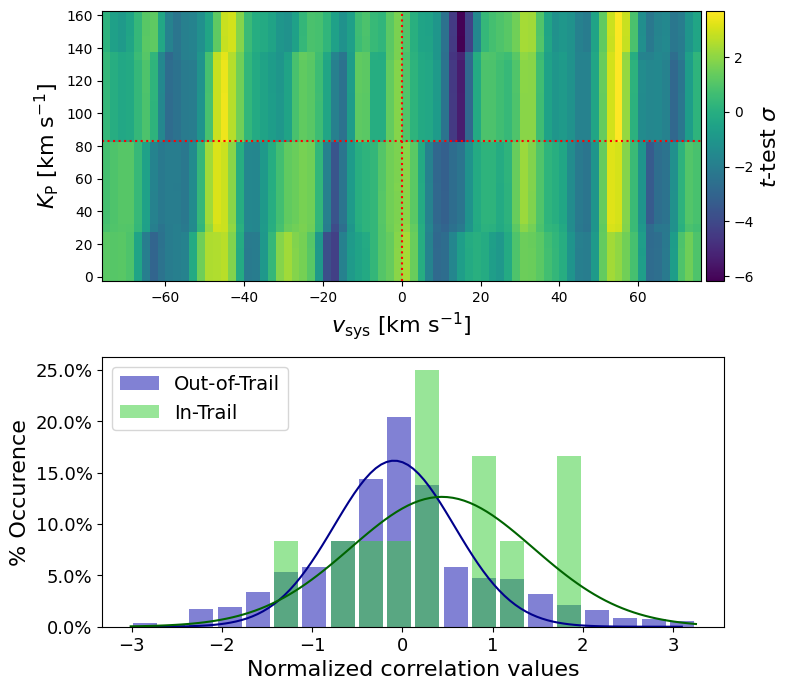

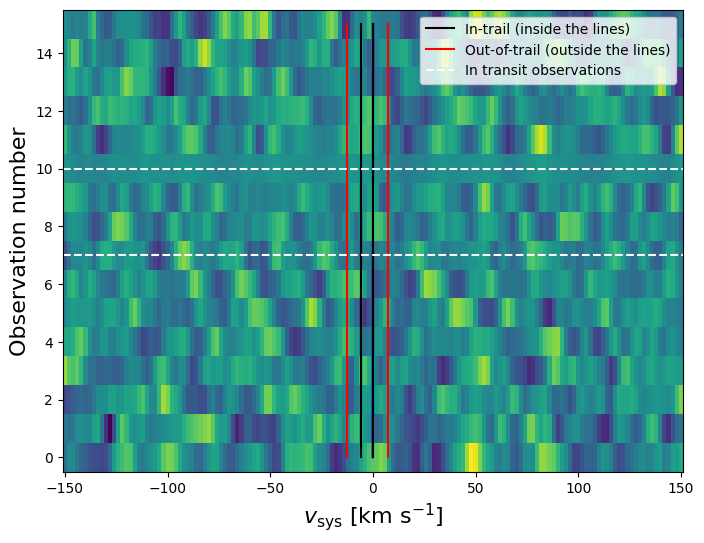

<Figure size 640x480 with 0 Axes>

In [13]:
# Generate the ttest map
ccf_obj.ttest_map(all_obs[(n_pc, mask_wings)], kind='logl', vrp=np.zeros_like(obs.vrp), orders=order_indices, 
                  kp0=0, RV_limit=75, kp_step=5, rv_step=2, RV=None, speed_limit=3, icorr=obs.iIn, equal_var=False
                  )

# Print info about the plots
print("\nInformation about the plots:\n" + pf.plot_ttest_map_hist.__doc__)

T-val : Max value = 0.9 // Max position = -1.3
Histogram for Kp = 82.83 and RV = -2.83


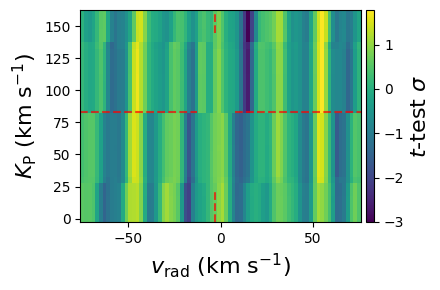

In [14]:
tr=all_obs[(n_pc, mask_wings)]
cobj = ccf_obj
t_value = cobj.ttest_map_tval

t_value_scaled = t_value*(-3)/t_value.min()

(t_in, p_in) = pf.plot_ttest_map_hist(tr, cobj.rv_grid, cobj.map_prf.copy(), 
                                           cobj.ttest_map_kp, cobj.ttest_map_rv, 
                                    t_value_scaled, cobj.ttest_map_params, 
                              plot_trail=True, masked=True, ccf=cobj.map_prf.copy(),
                              vrp=np.zeros_like(tr.vrp), RV=cobj.pos, hist=False,
                                      show_max=False, show_rest_frame=False,
                                    fig_name='', path_fig=None, orders=order_indices)
# fig.get_axes()[0].text(-67.0, 300, r'H$_2$O', fontsize=16, bbox ={'facecolor':'white', 'alpha':0.8})
fig = plt.gcf()
ax = fig.axes

pos_max = -3.2
# - Lines enclosing the maximum -
ax[0].axhline(tr.Kp.to(u.km / u.s).value, linestyle='--', alpha=0.7, color='r', 
              xmin=0,xmax=hm.nearest(cobj.interp_grid, pos_max-20)/cobj.interp_grid.size )
ax[0].axhline(tr.Kp.to(u.km / u.s).value, linestyle='--', alpha=0.7, color='r',
              xmin=hm.nearest(cobj.interp_grid, pos_max+20)/cobj.interp_grid.size ,xmax=1) 
ax[0].axvline(pos_max, linestyle='--', alpha=0.7, color='r', 
                  ymin=0, ymax=(tr.Kp.value - 60)/cobj.ttest_map_kp[-1] )
ax[0].axvline(pos_max, linestyle='--', alpha=0.7, color='r',
                  ymin=(tr.Kp.value + 60)/cobj.ttest_map_kp[-1] , ymax=1)
fig.set_size_inches(4.5,3)
plt.tight_layout()
#fig.savefig(data_path+'Figures/'+'t3_H2O_night.pdf', rasterize=True)

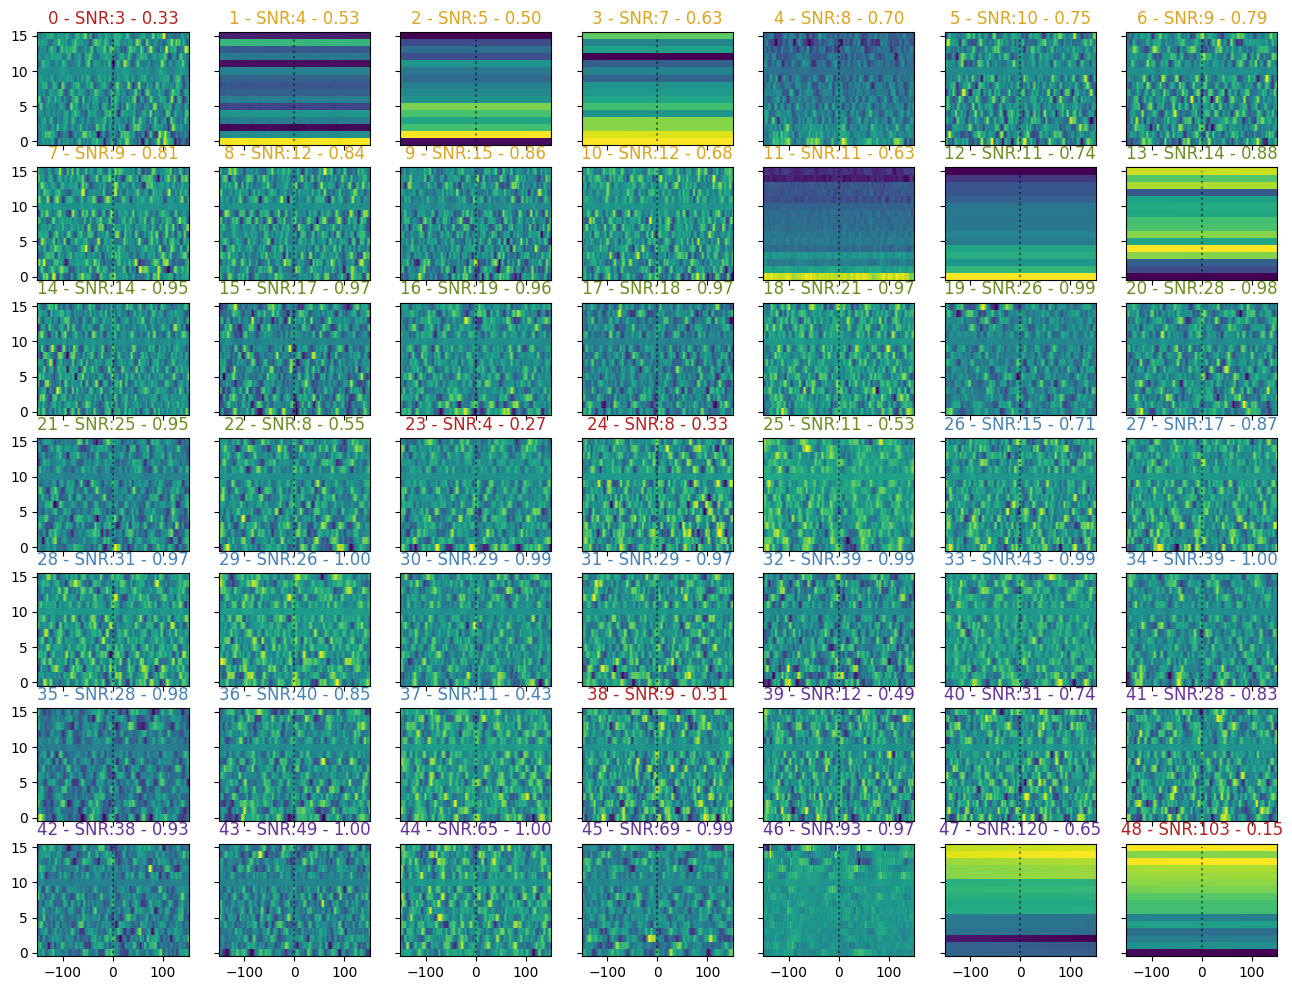

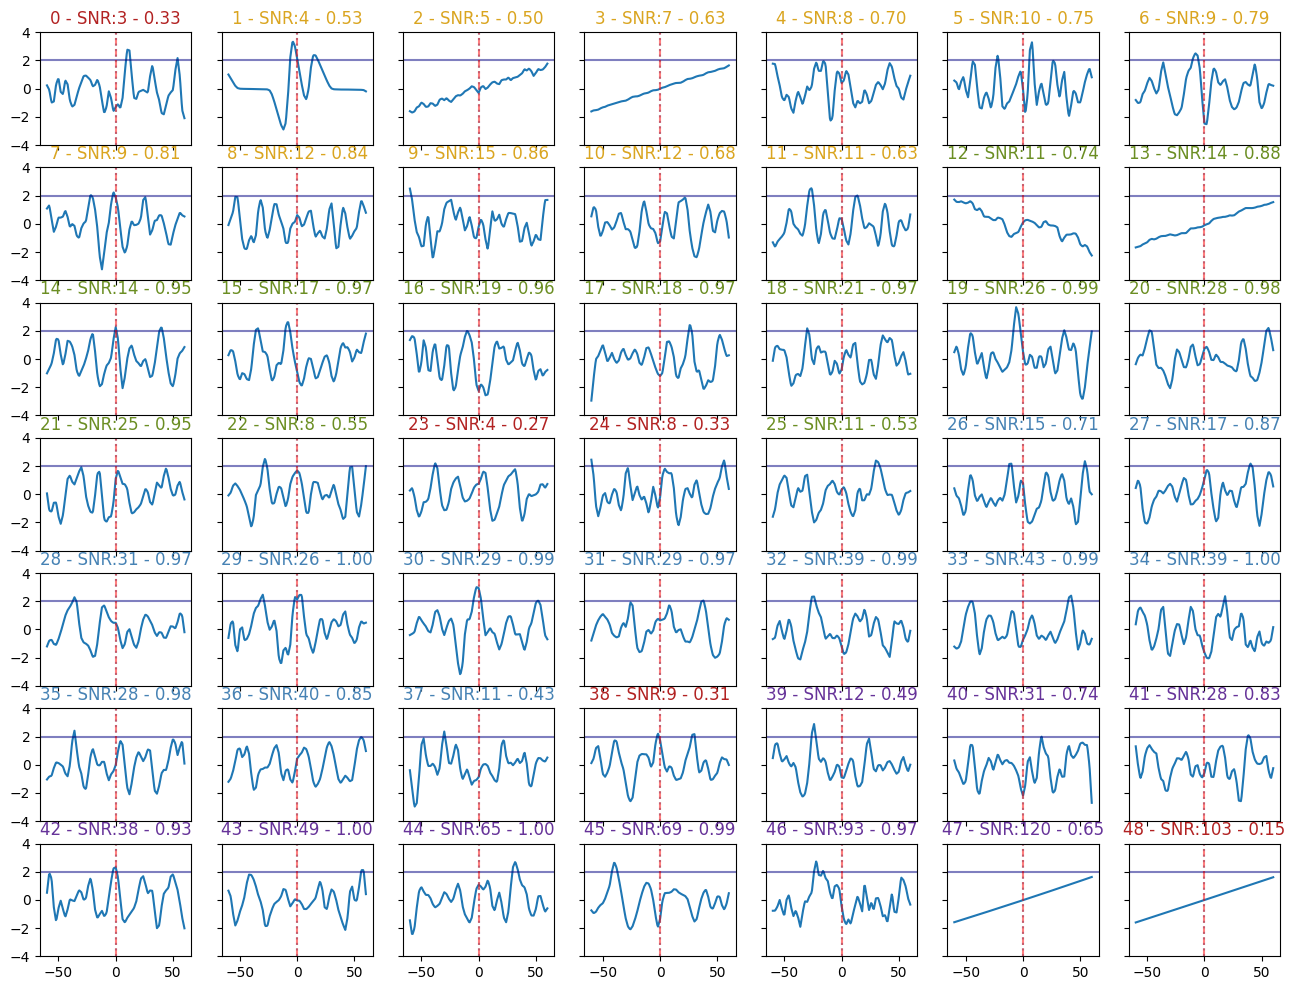

In [15]:
_ = pf.plot_all_orders_correl(corrRV0,ccf_obj.data.squeeze(), all_obs[(n_pc, mask_wings)],
                                      icorr=None, logl=False, sharey=True,
                                      vrp=np.zeros_like(all_obs[(n_pc, mask_wings)].vrp),
                              RV_sys=0.0, vmin=None, vmax=None,
                                      vline=None, hline=2, kind='snr', return_snr=True)

#### STOP HERE FOR NOW

In [33]:
from scipy.interpolate import interp1d

In [34]:
fct_model = interp1d(wave_mod, model_spec, kind='cubic')

In [35]:
%matplotlib inline

ValueError: A value (2.3498585197885875) in x_new is above the interpolation range's maximum value (2.3498560869708327).

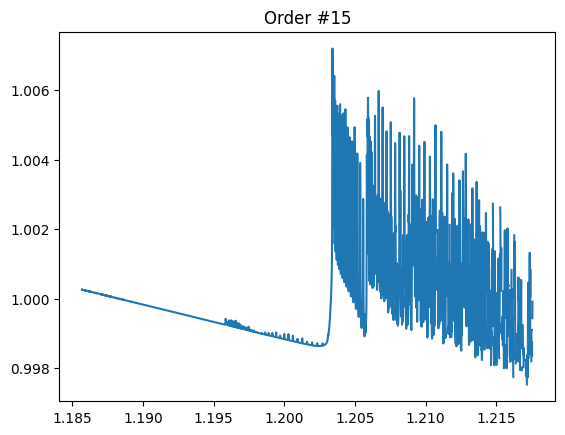

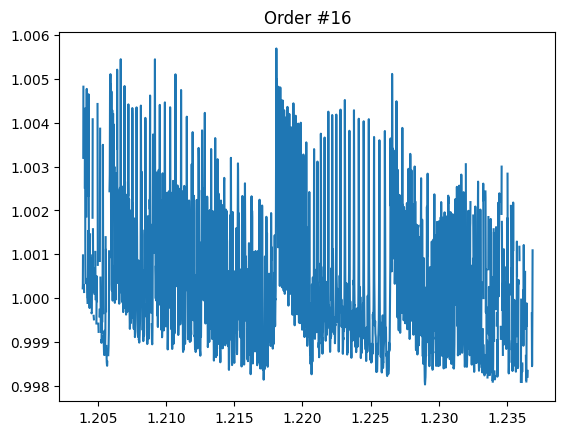

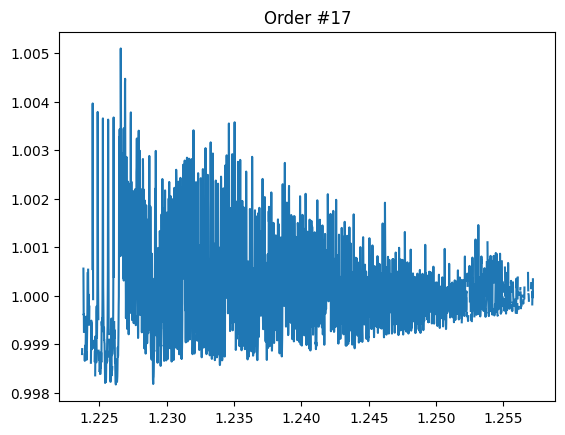

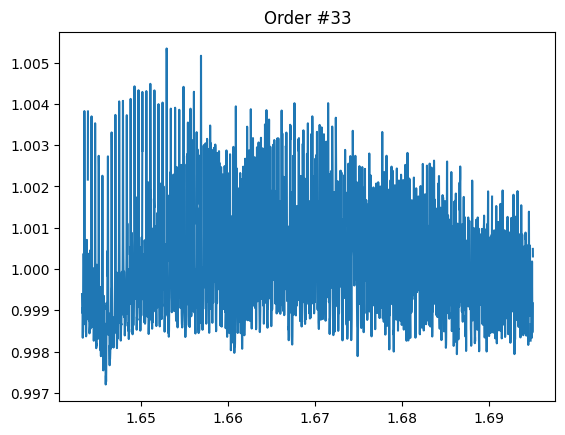

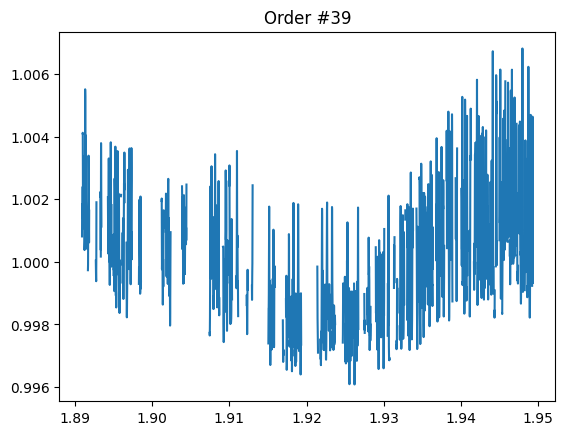

In [36]:
order_plot = [15, 16, 17, 33, 39, 46, 47]

for i_ord in order_plot:

    wv_ord = all_obs[(n_pc, mask_wings)].wv[i_ord]
    mask_ord = all_obs[(n_pc, mask_wings)].final.mask[0, i_ord]
    
    coeff = np.polyfit(wv_ord, fct_model(wv_ord), 1)
    model_ord = np.ma.array(fct_model(wv_ord), mask=mask_ord)
    
    plt.figure()
#     plt.plot(wave_mod[cond], model_spec[cond])
    poly_fct = np.poly1d(coeff)
    plt.plot(wv_ord, model_ord / poly_fct(wv_ord))
    plt.title("Order #" + str(i_ord))
    
#     plt.gca().twinx().plot(wv_ord, mask_ord, 'r')

In [40]:
all_obs[(n_pc, mask_wings)].wv, all_obs[(n_pc, mask_wings)].flux.mask.shape

(array([[0.95579711, 0.95580545, 0.9558138 , ..., 0.9861484 , 0.98615492,
         0.98616144],
        [0.96809692, 0.96810537, 0.96811383, ..., 0.99883102, 0.99883762,
         0.99884422],
        [0.98071801, 0.98072657, 0.98073512, ..., 1.01184193, 1.01184862,
         1.0118553 ],
        ...,
        [2.29116284, 2.29118264, 2.29120244, ..., 2.36323276, 2.36324825,
         2.36326374],
        [2.36280875, 2.36282917, 2.36284958, ..., 2.43711481, 2.43713078,
         2.43714675],
        [2.43908088, 2.43910195, 2.43912302, ..., 2.51576233, 2.5157788 ,
         2.51579526]]),
 (38, 49, 4088))

# Combine visits

In [15]:
reload(pl_obs)

<module 'starships.planet_obs' from '/home/adb/PycharmProjects/starships/planet_obs.py'>

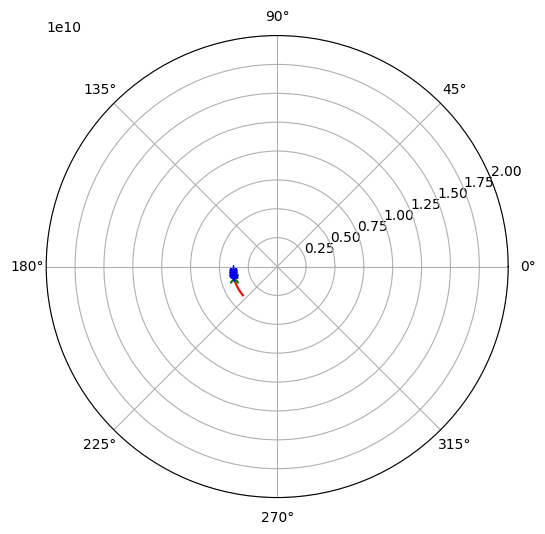

Emission
(38,) 38


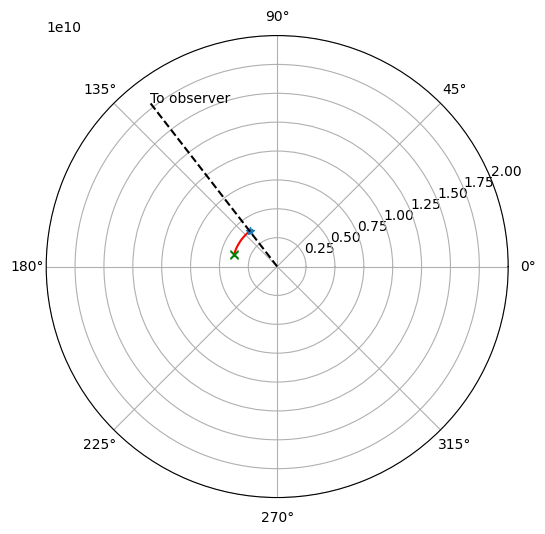

Emission
(34,) 34


In [35]:
model_name = 'best_fit_JR'
filename_dict = {
    '1': 'v07254_wasp33_2-pc_mask_wings95_data_trs_night1.npz',
    '2': 'v07254_wasp33_3-pc_mask_wings95_data_trs_night2.npz',
}

coeffs = [0.532]
ld_model = 'linear'
kind_trans='emission'
combined_ccf = []
combined_logl = []
combined_obs = []
visit_dict = dict()

for key, fname in filename_dict.items():
    obs = pl_obs.load_single_sequences(fname, pl_name, path=reduc_dir,
                              load_all=False, filename_end='', plot=False, planet=planet_obj)
    print(obs.vrp.shape, obs.n_spec)
    
    out_filename = f'{Path(fname).stem}_ccf_logl_seq_{model_name}'
    
    try:
        # Check if already generated
        saved_values = np.load(output_dir / Path(out_filename).with_suffix('.npz'))
        ccf_map = saved_values['corr']
        logl_map = saved_values['logl']
    except FileNotFoundError:
        # Generate 1d correlations
        # ccf_map shape: (n_exposures, n_order, n_Kp, n_vsys, n_pc, n_model) 
        ccf_map, logl_map = corr.calc_logl_injred(
            obs,'seq', planet_obj, Kp_array, corrRV0, [n_pc], wave_mod, model_spec,  kind_trans
        )
    
    
        corr.save_logl_seq(output_dir / Path(out_filename), ccf_map, logl_map,
                           wave_mod, model_spec, n_pc, Kp_array, corrRV0, kind_trans)

    visit_dict[key] = obs
    combined_obs.append(obs)
    combined_ccf.append(ccf_map)
    combined_logl.append(logl_map)


transit_tags = [np.arange(obs.n_spec) for obs in visit_dict.values()]
all_visits = pl_obs.gen_merge_obs_sequence(obs, visit_dict, [1, 2], None, 
                                    coeffs, ld_model, kind_trans, light=True)

In [159]:
for key, val in vars(obs).items():
    try:
        print(key, type(val), len(val))
    except TypeError:
        pass

name <class 'str'> 9
wave <class 'numpy.ndarray'> 38
count <class 'numpy.ndarray'> 0
blaze <class 'numpy.ma.core.MaskedArray'> 38
headers <class 'starships.list_of_dict.list_of_dict'> 0
headers_image <class 'starships.list_of_dict.list_of_dict'> 0
headers_tellu <class 'starships.list_of_dict.list_of_dict'> 0
filenames <class 'numpy.ndarray'> 38
uncorr <class 'numpy.ma.core.MaskedArray'> 38
tellu <class 'numpy.ma.core.MaskedArray'> 38
wv <class 'numpy.ndarray'> 49
params <class 'list'> 10
sep <class 'astropy.units.quantity.Quantity'> 38
noise <class 'numpy.ma.core.MaskedArray'> 38
N <class 'numpy.ma.core.MaskedArray'> 38
t_start <class 'numpy.ndarray'> 38
t <class 'astropy.units.quantity.Quantity'> 38
dt <class 'tuple'> 1
bad <class 'numpy.ndarray'> 0
flux <class 'numpy.ma.core.MaskedArray'> 38
ratio <class 'numpy.ma.core.MaskedArray'> 38
reconstructed <class 'numpy.ma.core.MaskedArray'> 38
N0 <class 'numpy.ma.core.MaskedArray'> 38
N_frac <class 'numpy.ndarray'> 49
mast_out <class 'nump

In [36]:
all_visits.dt = np.concatenate([vst.dt for vst in visit_dict.values()])

Max value at 1 npc = 4.510469459225703 at -1.2168618378472116 km/s
Max value at 1 npc = 4.527096059311357 at -1.218799602230119 km/s
Max value at 1 npc = 4.527096059311357 at -1.218799602230119 km/s
[4.51046946]
[31216.41805185]
[65.49139532]
[0.]
(72, 151)
0.3550404471536485 0.6112967267558851
[0.0027499053638643245, 0.002747314178890292]
0.0027486097713773083
(array([56, 57, 58]),)
In-transit t-val = 7.44 / p-val 4.40e-12 / sig = 6.82
Out-of-transit t-val = -3.97 / p-val 3.50e-04 / sig = 3.39
T-val : Max value = 8.7 // Max position = -2.5
Histogram for Kp = 230.55 and RV = -1.22
7.630544276590912 1.4776777449229804e-12 6.97983341788682
T-val : Max value = 4.5 // Max position = -2.5
Histogram for Kp = 230.55 and RV = -1.22


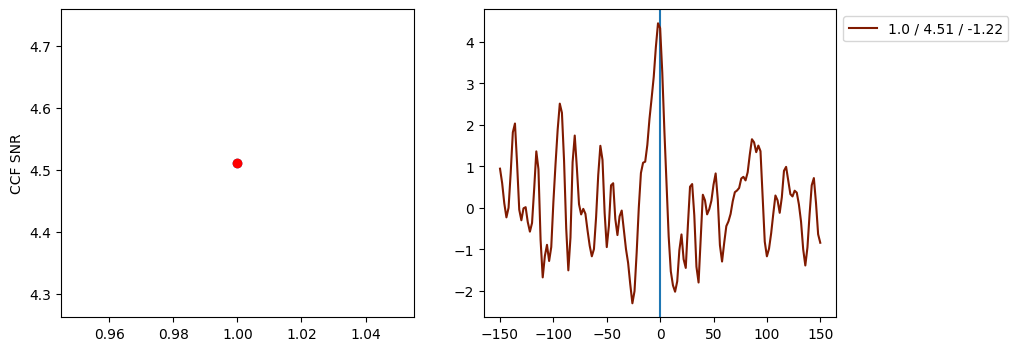

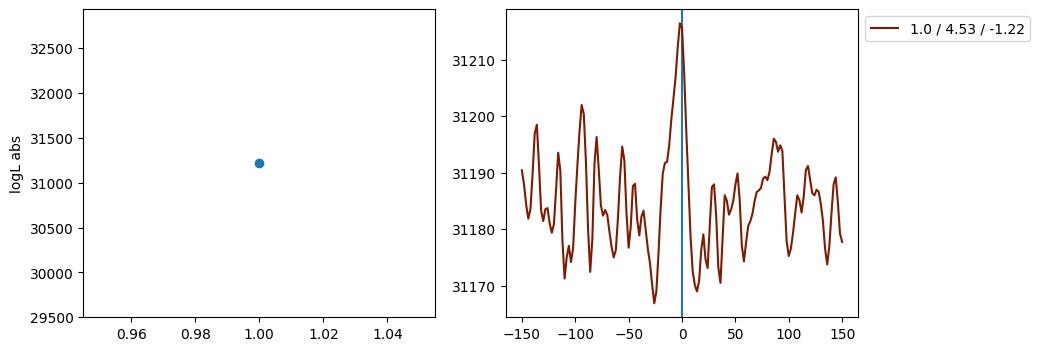

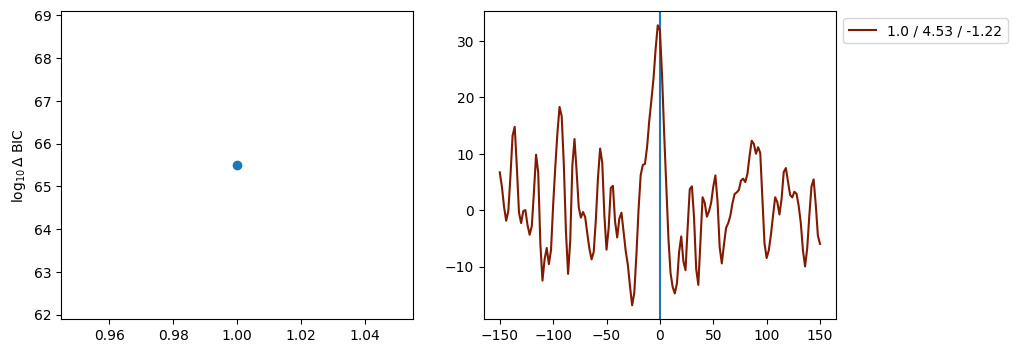

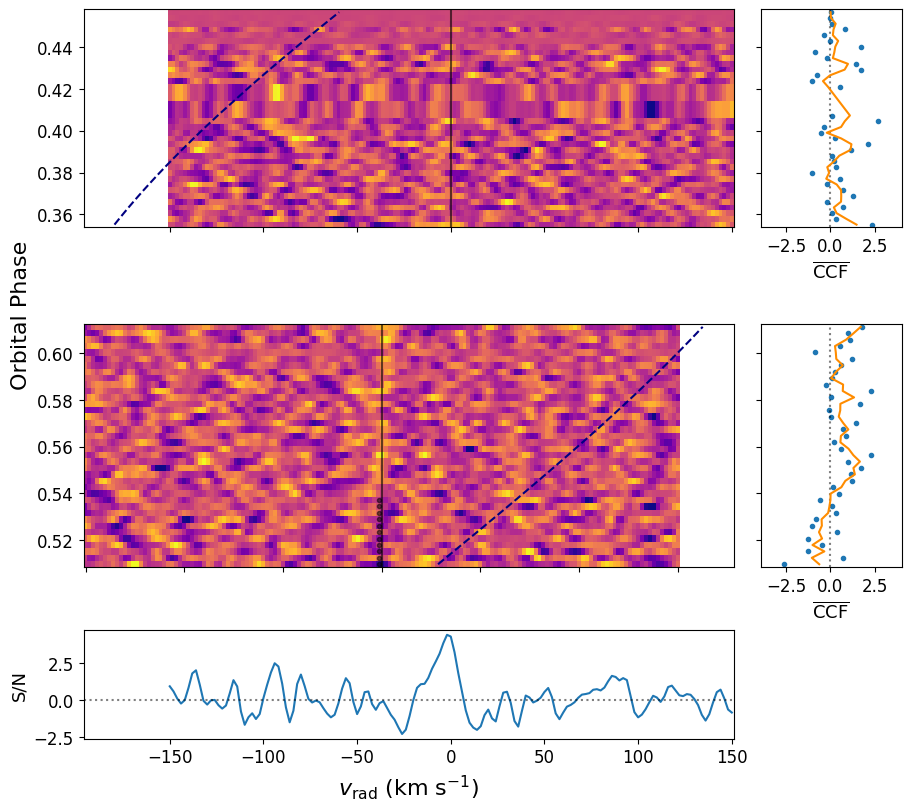

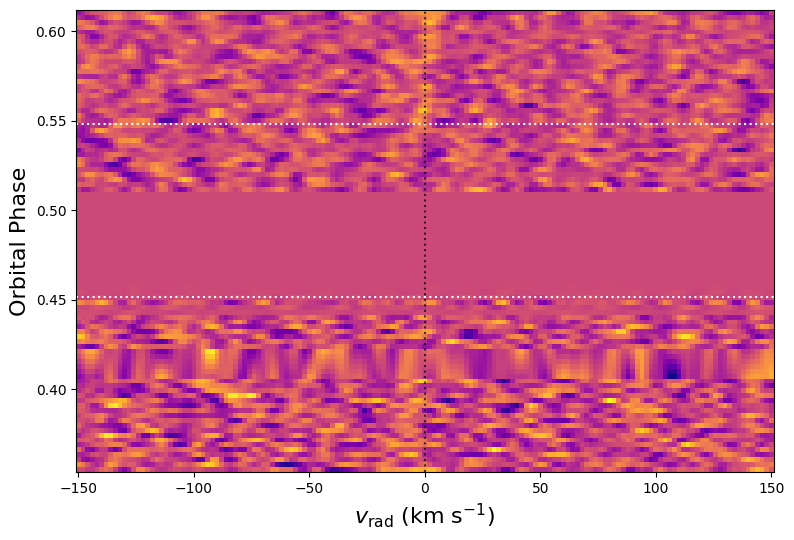

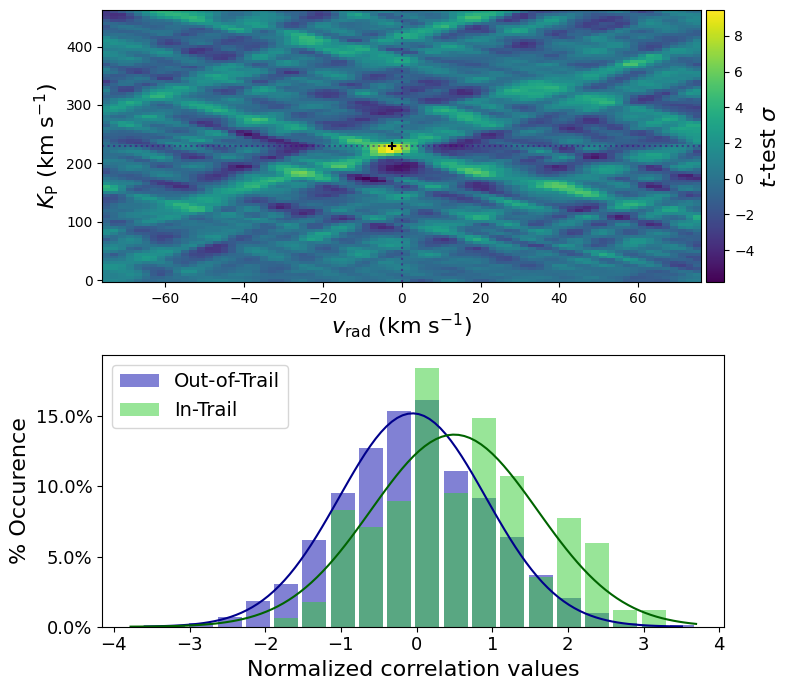

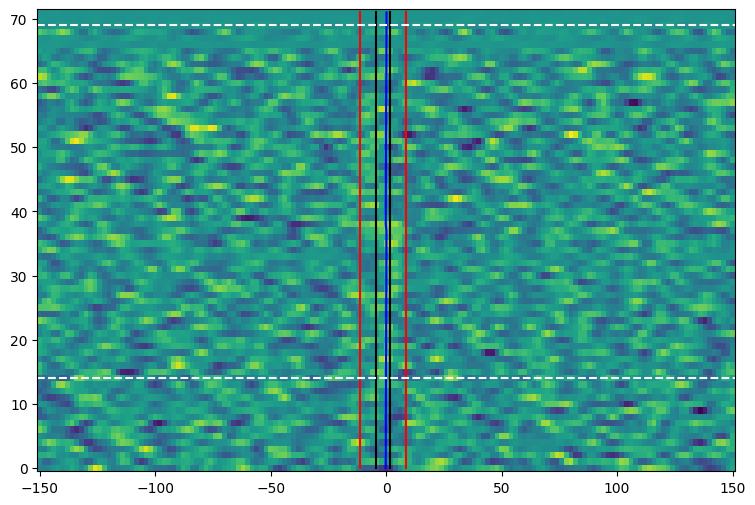

<Figure size 900x600 with 0 Axes>

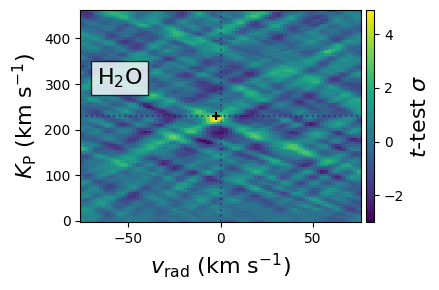

In [37]:
# Generate Kp 
Kp_array = np.array([obs.Kp.value]) 

ccf_map = np.concatenate(combined_ccf)
logl_map = np.concatenate(combined_logl)

t1 = combined_obs[0]
t2 = combined_obs[1]

idx_orders = np.array([46])  # np.arange(49)

ccf_obj, logl_obj = cc.plot_ccflogl(all_visits, 
                                    ccf_map,
                                    logl_map,
                                    corrRV0, Kp_array, [1],
                                    split_fig = [0,t1.n_spec,t1.n_spec+t2.n_spec],
                                    orders=idx_orders
                                   )

t=all_visits
ccf_obj.ttest_map(t, kind='logl', vrp=np.zeros_like(t.vrp), orders=idx_orders, 
                  kp0=0, RV_limit=75, kp_step=5, rv_step=2, RV=None, speed_limit=3, icorr=t.iIn, equal_var=False, 
                  )

tr=all_visits
cobj = ccf_obj
t_value = cobj.ttest_map_tval

(t_in, p_in), fig = pf.plot_ttest_map_hist(tr, cobj.rv_grid, cobj.map_prf.copy(), 
                                           cobj.ttest_map_kp, cobj.ttest_map_rv, 
                                    t_value*(-3)/t_value.min(), cobj.ttest_map_params, 
                              plot_trail=True, masked=True, ccf=cobj.map_prf.copy(),
                              vrp=np.zeros_like(tr.vrp), RV=cobj.pos, hist=False,
                                    fig_name='', path_fig=None, cmap='viridis')
fig.get_axes()[0].text(-67.0, 300, r'H$_2$O', fontsize=16, bbox ={'facecolor':'white', 'alpha':0.8})
plt.gcf().set_size_inches(4.5,3)
plt.tight_layout()
# fig.savefig(data_path+'Figures/fig_'+'all_visits_H2O_day.pdf', rasterize=True)

In [63]:
visit_dict['12'] = all_visits

In [57]:

args_filename = [(key, str(visit_dict[key].params[5]), str(int(visit_dict[key].params[1] * 100)))
                 for key in filename_dict.keys()]
args_filename = ['-'.join(values) for values in zip(*args_filename)]
filename = 'v07254_wasp33_nights{}_pc{}_mask_wings{}'.format(*args_filename)



In [58]:
pl_obs.save_sequences(filename, visit_dict, [1, 2, 12], path=reduc_dir)

/scratch/adb/DataAnalysis/SPIRou/Reductions/WASP-33/v07254_wasp33_nights1-2_pc2-3_mask_wings95-95_data_info.npz
/scratch/adb/DataAnalysis/SPIRou/Reductions/WASP-33/v07254_wasp33_nights1-2_pc2-3_mask_wings95-95_data_trs_0.npz
/scratch/adb/DataAnalysis/SPIRou/Reductions/WASP-33/v07254_wasp33_nights1-2_pc2-3_mask_wings95-95_data_trs_1.npz


In [27]:
pl_obs.save_sequences('v07254_wasp33_nights1_pc2_mask_wings95', visit_dict, [1], path=reduc_dir)

/scratch/adb/DataAnalysis/SPIRou/Reductions/WASP-33/v07254_wasp33_nights1_pc2_mask_wings95_data_info.npz
/scratch/adb/DataAnalysis/SPIRou/Reductions/WASP-33/v07254_wasp33_nights1_pc2_mask_wings95_data_trs_0.npz
